## Advanced Lane Lines Project

The purpose of this project is to create a pipeline which can detect the immediate left and right lane markings from the video stream of a forward facing camera in a vehicle. This pipeline will highlight the lane in the video, as well as report the curvature of the lane and the current lateral offset, or lateral displacement between the center of the lane and the center of the vehicle. 

### Calculate Camera Calibration Matrix for undistortion of images

I use the images in the camera_cal directory to determine the camera matrix and distortion parameters so that we can undistort images taken by the camera. The code used here is taken from https://github.com/udacity/CarND-Camera-Calibration with slight modifications

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
n_rows = 6
n_columns = 9
objp = np.zeros((n_rows*n_columns,3), np.float32)
objp[:,:2] = np.mgrid[0:n_columns, 0:n_rows].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    if idx == 0:
        img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (n_columns,n_rows), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (n_columns,n_rows), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
    else:
        print("unusable image: ", fname)
            

cv2.destroyAllWindows()

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["img_size"] = img_size
pickle.dump( dist_pickle, open( "camera_cal/cal_param.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)


unusable image:  camera_cal/calibration1.jpg
unusable image:  camera_cal/calibration4.jpg
unusable image:  camera_cal/calibration5.jpg


#### Define and test undistortion function

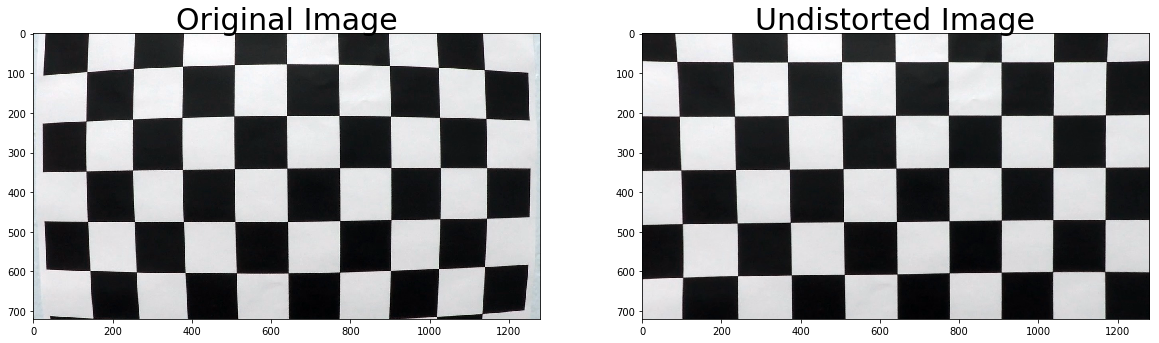

In [1]:
import matplotlib.pyplot as plt
import cv2
import pickle
%matplotlib inline

cal_param = pickle.load(open("camera_cal/cal_param.p","rb"))
mtx = cal_param["mtx"]
dist = cal_param["dist"]
img_size = cal_param["img_size"]


def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
    

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
dst = undistort(img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Color and Gradient filtering

To generate a binary image of lane marker pixels I run the following pipeline which uses color and gradient filters

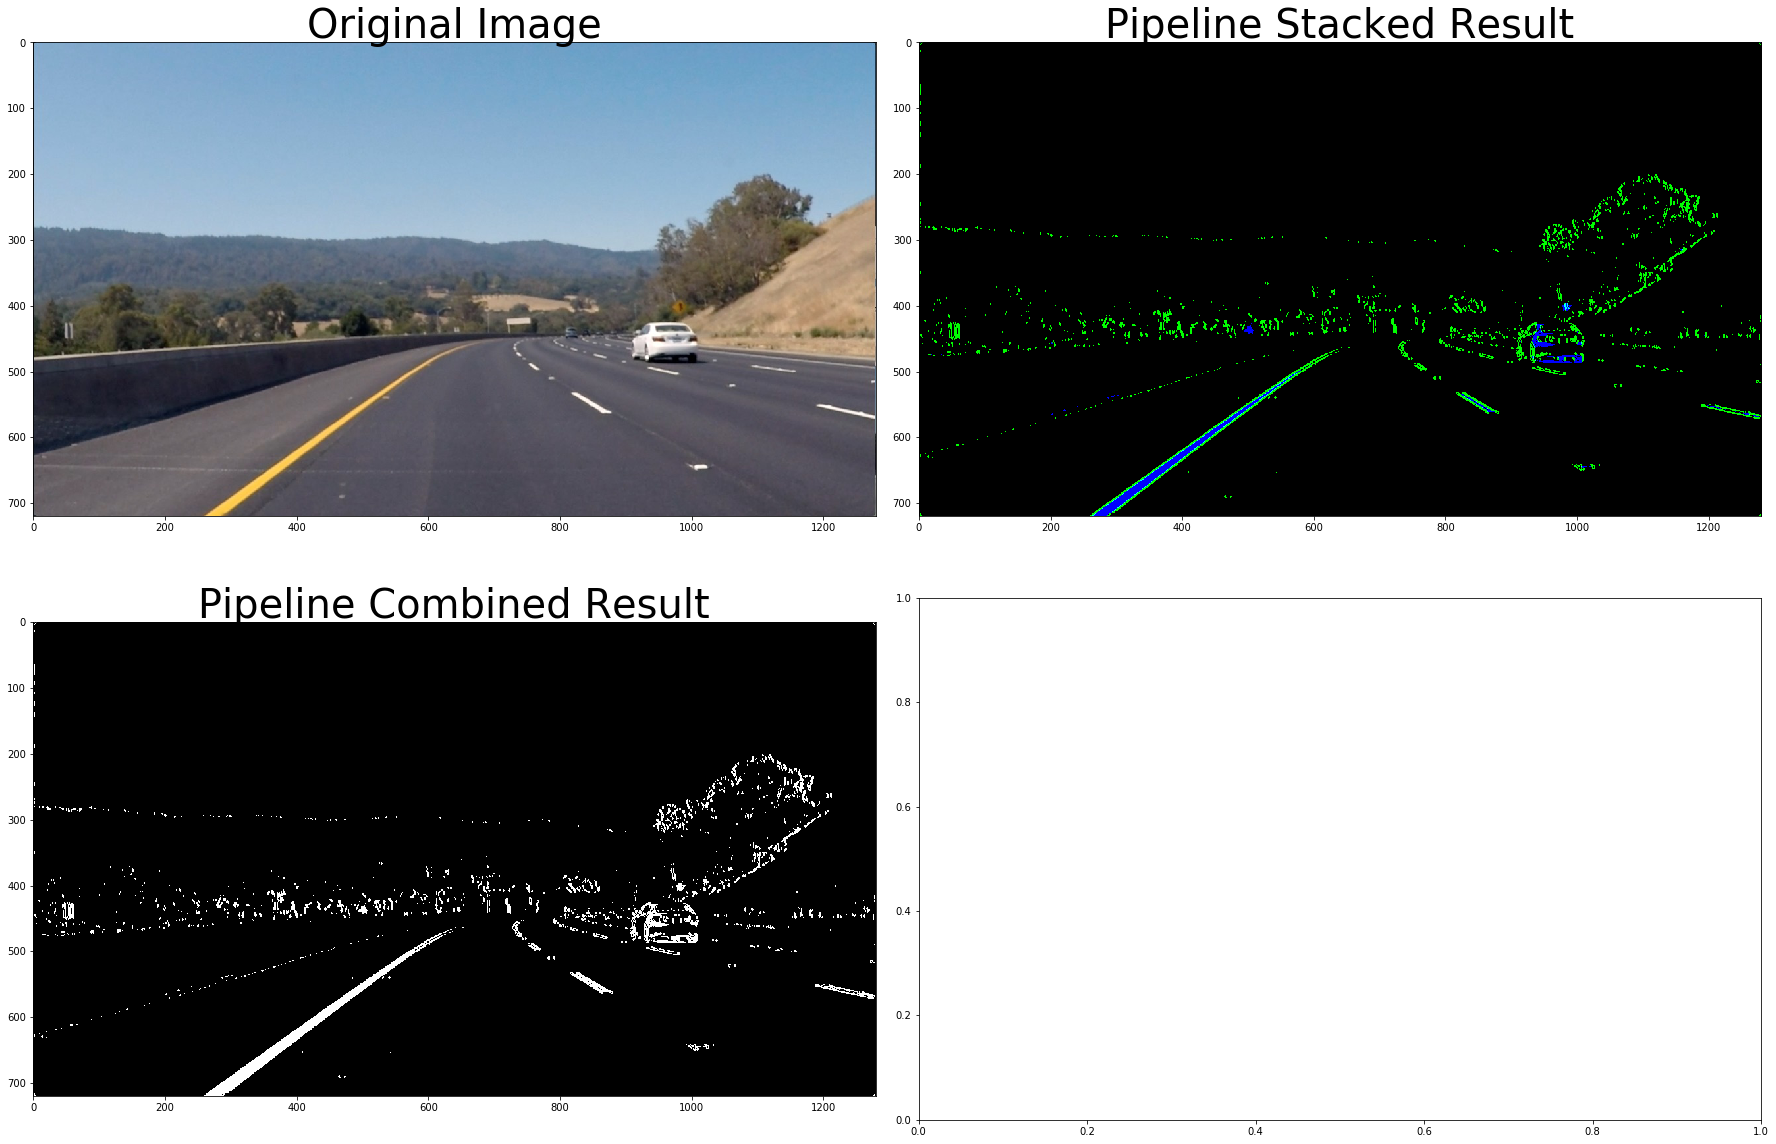

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread('test_images/test3.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)): #sx_thresh=(20, 100)
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary
    
result_c, result_b = pipeline(image)

# Plot the result
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result_c)
ax2.set_title('Pipeline Stacked Result', fontsize=40)

ax3.imshow(result_b,cmap='gray')
ax3.set_title('Pipeline Combined Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=1.7, bottom=0.)

### Perspective transform

To generate a "Birds-eye view" of the lane markers, a perspective transform needs to be applied to the image

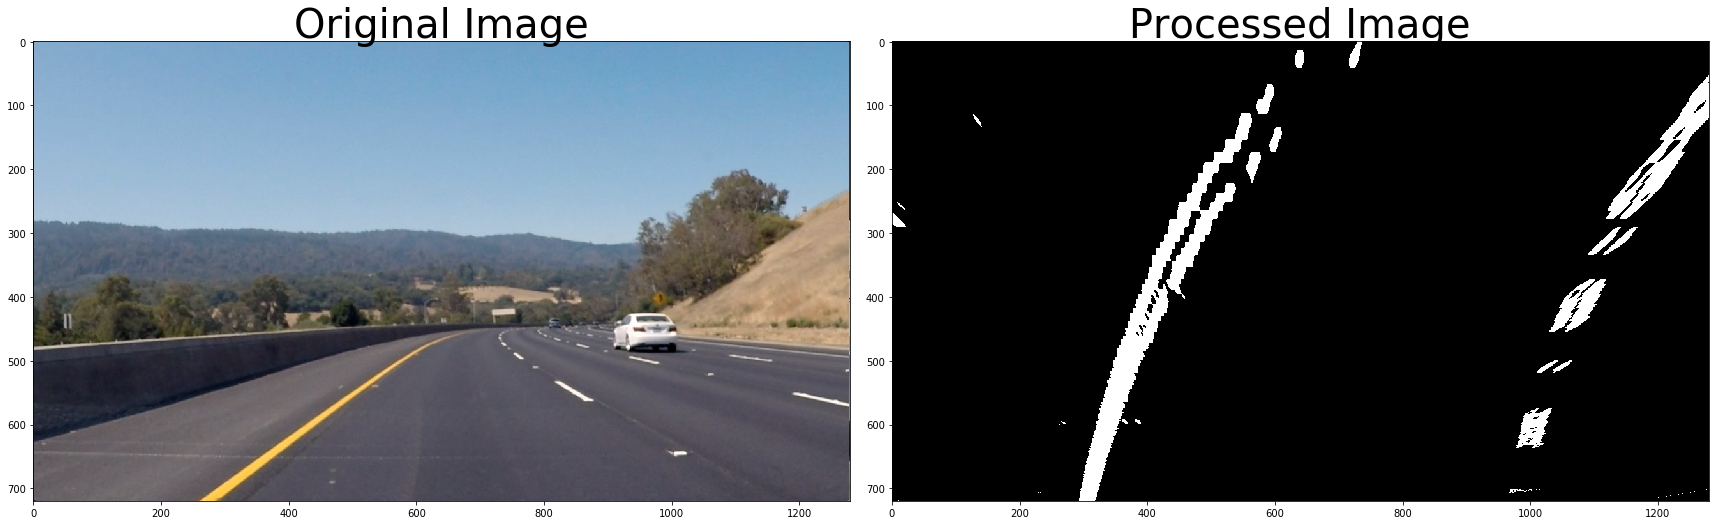

In [3]:
image = mpimg.imread('test_images/test3.jpg')

offset = 300
src = np.float32([[599,463],[684,463],[1075,683],[317,683]])
dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)

def warp(img):
    return cv2.warpPerspective(img,M,img_size)

def unwarp(img):
    return cv2.warpPerspective(img,Minv,img_size)

def process_image(img):
    result = pipeline(img)[1]
    return warp(result)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(process_image(image),cmap='gray')
ax2.set_title('Processed Image', fontsize=40)

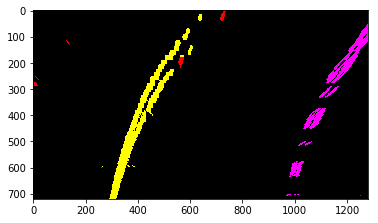

In [5]:
p_image = process_image(image)
histogram = np.sum(p_image[int(p_image.shape[0]/2):,:], axis=0)
#plt.plot(histogram)

def safe_index(low_index,high_index,length):
    return max(low_index,0),min(high_index,length)

def find_lane_marker_samples(b_image, min_col, max_col):
    lane_marker_samples = np.zeros_like(b_image)
    base_histogram = np.sum(b_image[int(b_image.shape[0]/2):,min_col:max_col], axis=0)
    starting_lane_marker_center = np.argmax(base_histogram) + min_col
    lane_marker_search_width = 75 #50
    vertical_image_sections = 8
    vertical_section_width = int(b_image.shape[0]/vertical_image_sections)
    end_row_index = b_image.shape[0]
    while end_row_index > 0:
        start_row_index,_ = safe_index(end_row_index - vertical_section_width,end_row_index,b_image.shape[0])
        start_col_index,end_col_index = safe_index(starting_lane_marker_center - lane_marker_search_width,
                                                  starting_lane_marker_center + lane_marker_search_width,
                                                  b_image.shape[1])
        image_section = b_image[start_row_index:end_row_index,start_col_index:end_col_index]
        section_histogram = np.sum(image_section,axis=0)
        if np.sum(section_histogram != 0):
            #only update starting_lane_marker_center if we find lane marker pixels
            starting_lane_marker_center = np.argmax(section_histogram)+start_col_index
        m_start,m_end = safe_index(starting_lane_marker_center-lane_marker_search_width,
                                  starting_lane_marker_center+lane_marker_search_width,
                                  b_image.shape[1])
        lane_marker_samples[start_row_index:end_row_index,m_start:m_end][b_image[start_row_index:end_row_index,m_start:m_end] == 1] = 1
        #update end_row_index
        end_row_index = start_row_index
    return lane_marker_samples

def lane_marker_samples(b_image):
    return find_lane_marker_samples(b_image,0,int(b_image.shape[1]/2)),find_lane_marker_samples(b_image,int(b_image.shape[1]/2),p_image.shape[1])


left_lane_marker_samples, right_lane_marker_samples = lane_marker_samples(p_image)

lane_highlights = np.dstack(( p_image, left_lane_marker_samples, right_lane_marker_samples))
lane_highlights = lane_highlights.astype(float)
plt.imshow(lane_highlights)



Radius of Curvature:  397.661679695


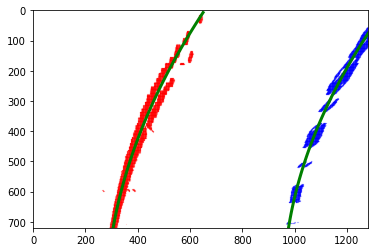

In [6]:
class LaneMarkerParams():
    def __init__(self):
        self.fit_values = None
        self.curverad = None
        self.lateral_offset = None
        

#calculate lane polynomials and curvature
def lane_polynomials(image,visualize=0):
    p_image = process_image(image)
    left_lane_marker_samples, right_lane_marker_samples = lane_marker_samples(p_image)

    #get indices of nonzero elements
    left_indicies = np.transpose(np.nonzero(left_lane_marker_samples))
    right_indicies = np.transpose(np.nonzero(right_lane_marker_samples))

    #plot left lane marker samples
    leftx = left_indicies[:,1]
    lefty = left_indicies[:,0]
    if visualize:
        plt.plot(leftx,lefty,'o',color='red',markersize=0.05)

    #plot right lane marker samples
    rightx = right_indicies[:,1]
    righty = right_indicies[:,0]
    if visualize:
        plt.plot(rightx,righty,'o',color='blue',markersize=0.05)

    #create the output classes
    LeftMarker = LaneMarkerParams()
    RightMarker = LaneMarkerParams()
    
    #fit left and right lane marker samples to 2nd order polynomial
    LeftMarker.fit_values = np.polyfit(lefty, leftx, 2)
    RightMarker.fit_values = np.polyfit(righty, rightx, 2)

    #generate values for fit visualization
    if visualize:
        yvals = np.linspace(1,100,num=101)*7.2
        left_fitx = LeftMarker.fit_values[0]*yvals**2 + LeftMarker.fit_values[1] * yvals + LeftMarker.fit_values[2]
        right_fitx = RightMarker.fit_values[0]*yvals**2 + RightMarker.fit_values[1] * yvals + RightMarker.fit_values[2]
        #plot fit
        plt.plot(left_fitx,yvals,color='green',linewidth=3)
        plt.plot(right_fitx,yvals,color='green',linewidth=3)

        #adjust plot layout
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.gca().invert_yaxis()

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    #calculate curve radius for left and right
    y_eval = np.max(lefty)*ym_per_pix
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    LeftMarker.curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    RightMarker.curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
    
    #calculate lateral offset for left and right
    #y_eval = y_eval*ym_per_pix
    vehicle_x = (image.shape[1] / 2) * xm_per_pix
    left_marker_x = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_marker_x = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
    LeftMarker.lateral_offset = vehicle_x - left_marker_x
    RightMarker.lateral_offset = vehicle_x - right_marker_x
        
    return LeftMarker, RightMarker
        
LeftMarker,RightMarker = lane_polynomials(image,1)
print('Radius of Curvature: ', (LeftMarker.curverad + RightMarker.curverad) / 2)

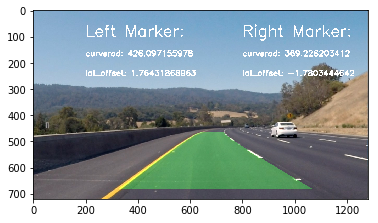

In [7]:
class PastFit():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False

#Highlight lane in original image
def lane_overlay(image, PastFit):
    
    if PastFit.detected == False:
        PastFit.detected = True
    else:
        PastFit.detected = True
    
    # Create an empty image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero)) #my image already has 3 channels
    color_warp = warp_zero
    
    #generate overlay polygon
    LeftMarker,RightMarker = lane_polynomials(image)
    yvals = np.linspace(1,100,num=101)*7.2
    left_fitx = LeftMarker.fit_values[0]*yvals**2 + LeftMarker.fit_values[1] * yvals + LeftMarker.fit_values[2]
    right_fitx = RightMarker.fit_values[0]*yvals**2 + RightMarker.fit_values[1] * yvals + RightMarker.fit_values[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    image = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    #add text overlay
    font = cv2.FONT_HERSHEY_SIMPLEX
    image = cv2.putText(image,'Left Marker:',(200,100), font, 2,(255,255,255),4)
    image = cv2.putText(image,'curverad: '+ str(LeftMarker.curverad),(200,175), font, 1,(255,255,255),4)
    image = cv2.putText(image,'lat_offset: '+ str(LeftMarker.lateral_offset),(200,250), font, 1,(255,255,255),4)
    
    image = cv2.putText(image,'Right Marker:',(800,100), font, 2,(255,255,255),4)
    image = cv2.putText(image,'curverad: '+ str(RightMarker.curverad),(800,175), font, 1,(255,255,255),4)
    image = cv2.putText(image,'lat_offset: ' + str(RightMarker.lateral_offset),(800,250), font, 1,(255,255,255),4)
    return image

plt.imshow(lane_overlay(image,PastFit()))

In [8]:
# Run algorithm on project video

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output.mp4'
input_video = VideoFileClip("project_video.mp4")
last_fit = PastFit()
lane_overlay_with_history = lambda x: lane_overlay(x,last_fit)
output_clip = input_video.fl_image(lane_overlay_with_history) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [03:23<00:00,  6.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 3min 16s, sys: 1min, total: 4min 17s
Wall time: 3min 25s


In [140]:
#play video
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output))

Apply the distortion correction to the raw image.
Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").
Detect lane pixels and fit to find lane boundary.
Determine curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.